# Trends in water limitation

Testing [Ukkola et al. 2016](https://www.nature.com/articles/nclimate2831) to see if using AusE-NDVI instead of GIMMS3g produces similar results.

In [1]:
import os
import sys
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import xarray as xr
from scipy import stats
import numpy as np
import scipy.signal
from scipy.stats import gaussian_kde
import contextily as ctx
import matplotlib.pyplot as plt
import odc.geo.xr
from odc.geo.xr import assign_crs

warnings.simplefilter('ignore')

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

## Analysis Parameters

Start with 5km resolution datasets to speed up exploration

In [2]:
rain_path = '/g/data/os22/chad_tmp/AusENDVI/data/5km/rain_5km_monthly_1981_2022.nc'
ndvi_path = '/g/data/os22/chad_tmp/AusENDVI/data/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc'
chunks=None#dict(latitude=1000, longitude=1000, time=-1)

t_range='1982', '2022'

## Open data

In [3]:
ndvi = assign_crs(xr.open_dataset(ndvi_path)['NDVI'], crs='EPSG:4326')
ndvi = ndvi.sel(time=slice(t_range[0], t_range[1]))

# base = '/g/data/os22/chad_tmp/AusENDVI/data/'
# ndvi = xr.open_dataset(base+'NDVI_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc').rename({'__xarray_dataarray_variable__':'NDVI'})['NDVI']
# # ndvi = assign_crs(ndvi, crs=crs)
# ndvi.attrs['nodata'] = np.nan

rain = assign_crs(xr.open_dataset(rain_path)['rain'], crs='EPSG:4326')
rain = rain.sel(time=slice(t_range[0], t_range[1]))

### Mask cropping and heavily wooded regions

In [4]:
ag = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/Landcover_1km_monthly_2002_2021.nc').isel(time=0),
                crs='epsg:4326')
ag = xr.where(ag==40,1,0)
ag = ag.odc.reproject(ndvi.odc.geobox, resampling='mode')
ag = round_coords(ag)
ag = ~ag.astype(bool)

#Woody cover fraction mask
trees = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = assign_crs(trees, crs ='epsg:4326')
trees = trees.sel(time=slice('2001', '2018'))
trees = trees.mean('time')

trees_mask = xr.where(trees>0.25, 1, 0)
non_trees_mask = xr.where(trees<=0.25, 1, 0)

In [5]:
ndvi = ndvi.where(ag)
rain = rain.where(rain)

ndvi= ndvi.where(non_trees_mask)
rain= rain.where(non_trees_mask)

In [6]:
# rain_corr = xr.corr(rain, ndvi, dim='time')

## Map precip to ndvi

Rolling 5-year means of annual NDVI and rainfall

In [7]:
ndvi_annual = ndvi.groupby('time.year').max('time')
ndvi_annual = ndvi_annual.where(ndvi_annual>0) 
rain_annual = rain.groupby('time.year').sum('time')
rain_annual = rain_annual.where(ndvi_annual>0)

ndvi_annual = ndvi_annual.rolling(year=5, min_periods=5).mean()
rain_annual = rain_annual.rolling(year=5, min_periods=5).mean()

### Extract 95th percentile of rainfall bins 

In [8]:
bins=np.arange(120,1500, step=20)
years = range(1986,2023)
Fx_edge = {}

for year in years:
    x = ndvi_annual.sel(year=year)
    y = rain_annual.sel(year=year)
    
    q_for_bin = []
    for b in bins:
        mask = xr.where((y<=b) & (y>b-20), 1, 0)
        q = x.where(mask).quantile([0.95])
        q_for_bin.append(q.data[0])

    Fx_edge[str(year)]=q_for_bin

df = pd.DataFrame(Fx_edge, index=bins)    

In [9]:
# plot_df = rain_annual.sel(year=2015).drop('spatial_ref').to_dataframe().drop('year', axis=1).reset_index(drop=True)
# plot_df['ndvi'] = ndvi_annual.sel(year=2015).drop('spatial_ref').to_dataframe().drop('year', axis=1).reset_index(drop=True)
# plot_df=plot_df.dropna()
# plot_df = plot_df.sample(50000)

### Plot a given year

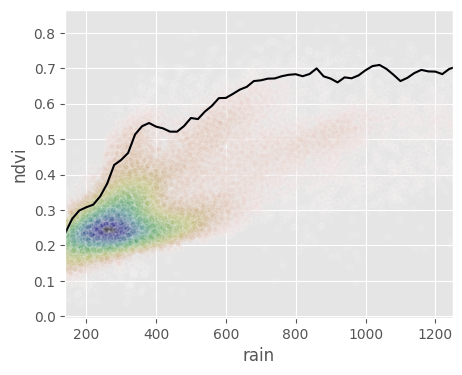

In [10]:
plt.style.use('ggplot')
year = 2015

plot_df = rain_annual.sel(year=year).drop('spatial_ref').to_dataframe().drop('year', axis=1).reset_index(drop=True)
plot_df['ndvi'] = ndvi_annual.sel(year=year).drop('spatial_ref').to_dataframe().drop('year', axis=1).reset_index(drop=True)
plot_df=plot_df.dropna()
plot_df = plot_df.sample(25000)

fig,ax=plt.subplots(1,1, figsize=(5,4))

obs, pred = plot_df['rain'].values, plot_df['ndvi'].values
xy = np.vstack([obs,pred])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=plot_df, x='rain',y='ndvi', c=z, s=20, lw=1, alpha=0.1, ax=ax, cmap='gist_earth_r')
df[str(year)].plot(cmap='inferno', ax=ax, legend=False);
ax.set_xlim(140,1250);


## Break point and slope analysis

In [11]:
import jenkspy

In [12]:
brk_pts_rain = []
brk_pts_ndvi = []
slopes = []

for year in years:

    y = df[str(year)].values
    idx=np.isfinite(y)
    y = y[idx]
    
    # break-point detection
    bp = jenkspy.jenks_breaks(y, n_classes=3)
    bp = bp[2]
    brk_pts_ndvi.append(bp)

    # #find rainfall value at BP
    bp_idx = df[str(year)][df[str(year)]==bp].index[0]
    brk_pts_rain.append(bp_idx)

    # Slope between 0 and break-point
    m, b = np.polyfit(x=df[idx].index[df[idx].index<=bp_idx].values,
                      y=y[df[idx].index<=bp_idx],
                      deg=1)
    
    slopes.append(m)

In [13]:
brk_pts = pd.DataFrame(data=brk_pts_ndvi, index=brk_pts_rain).reset_index()
brk_pts = brk_pts.rename({0:'NDVI', 'index':'breakpoint'},axis=1)
brk_pts['year'] = years

slopes = pd.DataFrame(data=slopes, index=years).reset_index()
slopes = slopes.rename({0:'slopes', 'index':'year'},axis=1)

### Plot all years

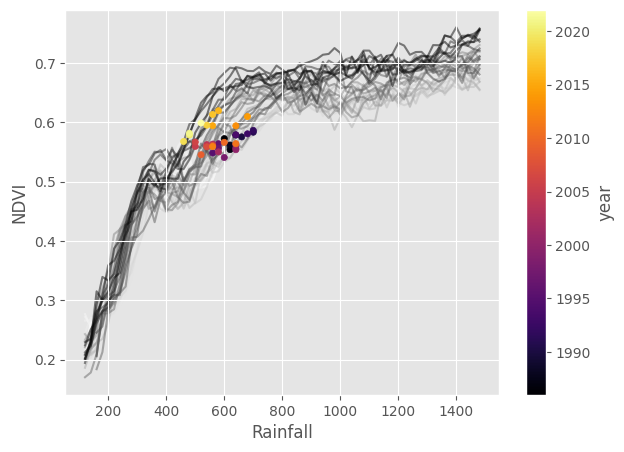

In [14]:
fig,ax=plt.subplots(1,1, figsize=(7,5))
df.plot(ax=ax, legend=False, cmap='Greys', zorder=-1, alpha=0.5);
brk_pts.plot(x='breakpoint', y='NDVI', ax=ax, kind='scatter', c='year', alpha=1,
             cmap='inferno', zorder=1
            )
ax.set_ylabel('NDVI');
ax.set_xlabel('Rainfall');

## Plot trends in slope and breakpoint

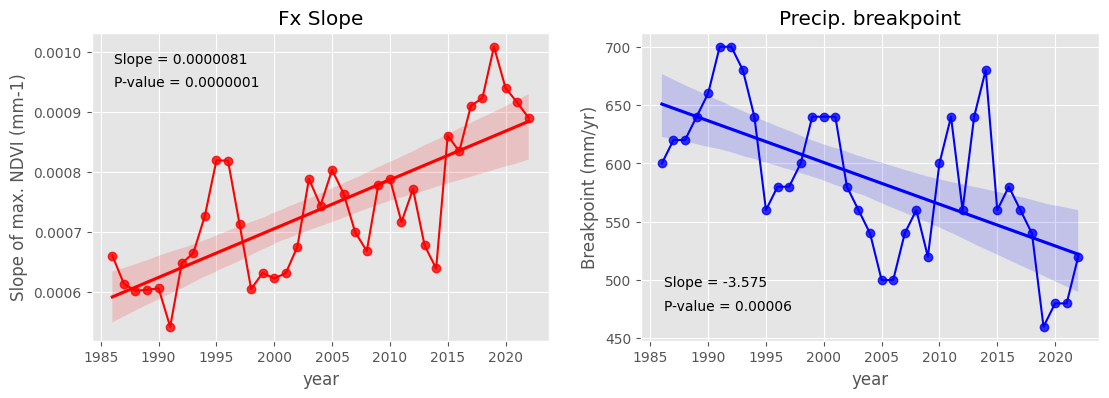

In [15]:
fig,ax=plt.subplots(1,2, figsize=(13,4))

sb.lineplot(data=slopes, x="year", y="slopes", ax=ax[0], color='r')
sb.regplot(x="year", y="slopes", data=slopes, ax=ax[0],color='r');

s, i, r, p, se = stats.linregress(slopes['year'].values,slopes['slopes'].values)
ax[0].text(.05, .90, 'Slope = {:.7f}'.format(s),
        transform=ax[0].transAxes, fontsize=10)
ax[0].text(.05, .825, 'P-value = {:.7f}'.format(p),
        transform=ax[0].transAxes, fontsize=10)

sb.lineplot(data=brk_pts, x="year", y="breakpoint", ax=ax[1], color='b')
sb.regplot(data=brk_pts, x="year", y="breakpoint", ax=ax[1], color='b');

s, i, r, p, se = stats.linregress(brk_pts['year'].values,brk_pts['breakpoint'].values)
ax[1].text(.05, .175, 'Slope = {:.4g}'.format(s),
        transform=ax[1].transAxes, fontsize=10)
ax[1].text(.05, .10, 'P-value = {:.5f}'.format(p),
        transform=ax[1].transAxes, fontsize=10)

# ax[0].plot(years, [i*1000 for i in slopes])
ax[0].set_title('Fx Slope');
ax[0].set_ylabel('Slope of max. NDVI (mm-1)')

# ax[1].plot(years, brk_pts)
ax[1].set_title('Precip. breakpoint')
ax[1].set_ylabel('Breakpoint (mm/yr)');